# Calculate titers of RBD mutant spike-pseudotyped lentiviruses
Experiments by Rachel Eguia.

In [1]:
import os
import warnings

import math
import numpy as np 

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import pandas as pd
from plotnine import *

In [2]:
warnings.simplefilter('ignore')

Make output directory if needed

In [3]:
resultsdir = './results/entry_titers'
os.makedirs(resultsdir, exist_ok=True)

In [4]:
titerdir = 'data/entry_titers/'
titers = pd.DataFrame() # create empty data frame

for f in os.listdir(titerdir):
    titerfile = os.path.join(titerdir, f)
    print(titerfile)
    titers = titers.append(pd.read_csv(titerfile)).reset_index(drop=True)
    
titers = (titers
          .assign(RLUperuL=lambda x: x['RLU_per_well'] / x['uL_virus'],
                  date=lambda x: x['date'].astype(str),
                  date_rescued=lambda x: x['date_rescued'].astype(str)
                 )
         )

display(HTML(titers.head().to_html(index=False)))

data/entry_titers/12Nov21_infection_titers.csv


plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,date_rescued,cell_type,RLUperuL
NaN,rep1,Delta_WT,0.10000,10.000,344077,12-Nov-21,5-Nov-21,293T-ACE2-TMPRSS2,34407.7
NaN,rep1,Delta_WT,0.05000,5.000,207846,12-Nov-21,5-Nov-21,293T-ACE2-TMPRSS2,41569.2
NaN,rep1,Delta_WT,0.02500,2.500,59660,12-Nov-21,5-Nov-21,293T-ACE2-TMPRSS2,23864.0
NaN,rep1,Delta_WT,0.01250,1.250,33656,12-Nov-21,5-Nov-21,293T-ACE2-TMPRSS2,26924.8
NaN,rep1,Delta_WT,0.00625,0.625,13816,12-Nov-21,5-Nov-21,293T-ACE2-TMPRSS2,22105.6


In [5]:
print(titers['virus'].unique())

['Delta_WT' 'Delta_E484K' 'Delta_K444N' 'Delta_G446V' 'Delta_S494L'
 'Delta_K417N' 'Delta_E484Q' 'VSV-G' 'No_VEP' 'Delta_R452L' 'Delta_R346G']


Saving to ./results/entry_titers/RLU-vs-uL.pdf


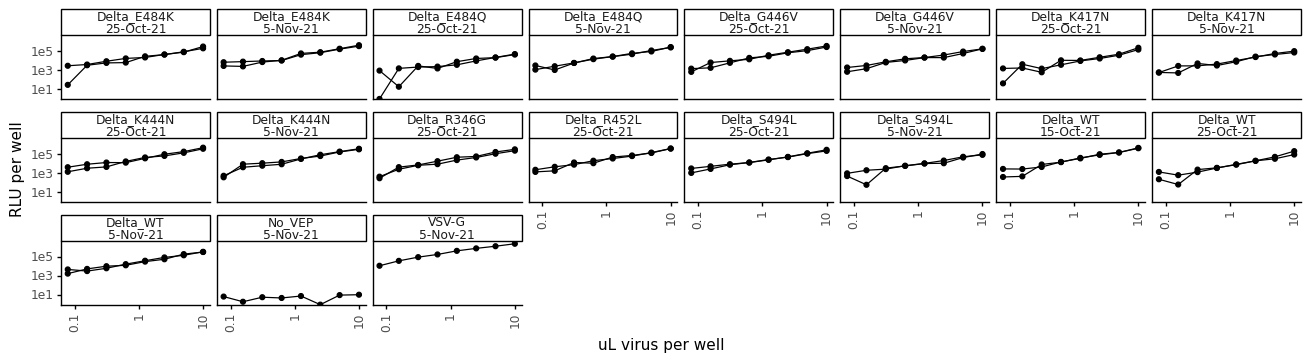

In [6]:
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(titers.drop(columns=['plasmid']).dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date_rescued', ncol=ncol) +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2 * ncol, 1.75 * nrow),
           )
     )

_ = p.draw()

plotfile = os.path.join(resultsdir, 'RLU-vs-uL.pdf')
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to ./results/entry_titers/RLUperuL.pdf


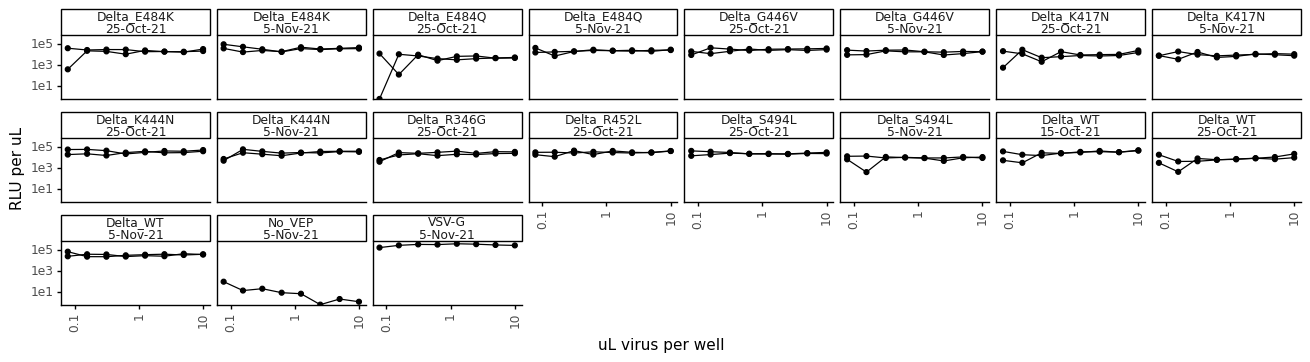

In [7]:
p = (ggplot(titers.drop(columns=['plasmid']).dropna()
            ) +
     aes('uL_virus', 'RLUperuL', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date_rescued', ncol=ncol) +
     scale_y_log10(name='RLU per uL') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2 * ncol, 1.75 * nrow),
           ) 
     )

_ = p.draw()

plotfile = os.path.join(resultsdir, 'RLUperuL.pdf')
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

From visual inspection of the above plots, it appears that only the 5 highest dilutions (i.e., >0.5uL of virus per well) are reliable enough to calculate titers. 

In [8]:
average_titers = (titers
                  .query('uL_virus > 0.5') # drop lowest concentration of virus
                  .groupby(['virus', 'replicate', 'date_rescued'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers.head().to_html(index=False)))

virus,replicate,date_rescued,mean_RLUperuL
Delta_E484K,rep1,25-Oct-21,18584.98
Delta_E484K,rep1,5-Nov-21,36906.40
Delta_E484K,rep2,25-Oct-21,23217.76
Delta_E484K,rep2,5-Nov-21,30786.36
Delta_E484Q,rep1,25-Oct-21,4195.08


Saving to ./results/entry_titers/entry_titers.pdf


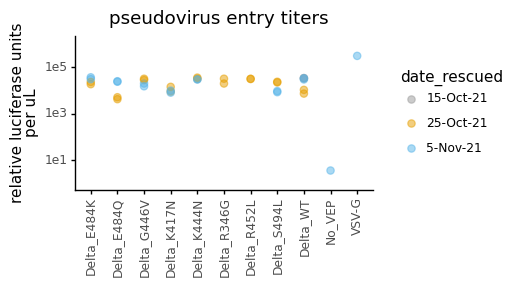

In [9]:
p = (ggplot(average_titers, 
            aes(x='virus', y='mean_RLUperuL', color='date_rescued')
           ) +
     geom_point(size=2.5, alpha=0.5)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*0.35,2),
           axis_title_x=element_blank(),
          ) +
     scale_y_log10(limits=[1,1.1e6]) +
     ylab('relative luciferase units\nper uL')+
     labs(title='pseudovirus entry titers') +
     scale_color_manual(values=CBPALETTE)
    )

_ = p.draw()

plotfile = os.path.join(resultsdir, 'entry_titers.pdf')
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Calculate how much virus to use in neut assays:

In [10]:
target_RLU = 2.5e5
uL_virus_per_well = 50

dilute_virus = (average_titers
                .groupby(['virus', 'date_rescued'])
                .agg(RLUperuL=pd.NamedAgg(column='mean_RLUperuL', aggfunc=np.mean))
                .reset_index()
                .assign(target_RLU = target_RLU,
                        uL_virus_per_well = uL_virus_per_well,
                        dilution_factor = lambda x: x['RLUperuL']/target_RLU*uL_virus_per_well,
                        uL_per_6mL = lambda x: 6000/x['dilution_factor']
                       )
               )


titerfile = os.path.join(resultsdir, 'titers.csv')
print(f"Saving to {titerfile}")

dilute_virus.to_csv(titerfile, index=False)

display(HTML(dilute_virus.head().to_html(index=False)))

Saving to ./results/entry_titers/titers.csv


virus,date_rescued,RLUperuL,target_RLU,uL_virus_per_well,dilution_factor,uL_per_6mL
Delta_E484K,25-Oct-21,20901.37,250000.0,50,4.180274,1435.312613
Delta_E484K,5-Nov-21,33846.38,250000.0,50,6.769276,886.357714
Delta_E484Q,25-Oct-21,4640.78,250000.0,50,0.928156,6464.430548
Delta_E484Q,5-Nov-21,24338.88,250000.0,50,4.867776,1232.595748
Delta_G446V,25-Oct-21,29982.01,250000.0,50,5.996402,1000.600026
